In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from os import path
from glob import glob
import math
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
plt.gray() # Make images gray
import numpy as np
from skimage.transform import resize
import scipy
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

from dumbrain.lib.download import downloadAndUnzip
from dumbrain.lib.plot import plotImageGrid, plotImageGridFunc

/home/mike/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<Figure size 432x288 with 0 Axes>

### First, get the data

In [3]:
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip', 'data/' )
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip', 'data/' )

9478144it [00:02, 3732446.55it/s]                             
100%|██████████| 4810560/4810560 [00:03<00:00, 1283755.35it/s]
6471680it [00:02, 2849191.20it/s]                             
100%|██████████| 3371735/3371735 [00:02<00:00, 1358495.97it/s]


### Understanding the data, and the problem

Fellowship.ai challenge problem statement

> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

30 20


(array([ 4.,  4., 16.,  3.,  3.,  0.,  9.,  6.,  3.,  2.]),
 array([14. , 18.1, 22.2, 26.3, 30.4, 34.5, 38.6, 42.7, 46.8, 50.9, 55. ]),
 <a list of 10 Patch objects>)

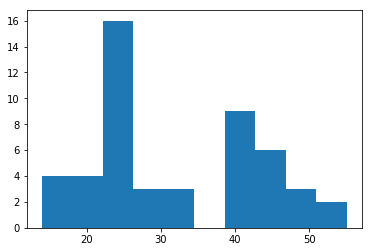

In [4]:
background_language_folders = glob( 'data/images_background/*' )
evaluation_language_folders = glob( 'data/images_evaluation/*' )
print( len( background_language_folders ), len( evaluation_language_folders ) )

character_counts = np.zeros( len( background_language_folders ) + len( evaluation_language_folders ), dtype=np.int )
for i, language_folder in enumerate( background_language_folders + evaluation_language_folders ):
    characters = glob( f'{language_folder}/*' )
    character_counts[ i ] = len( characters )

plt.hist( character_counts )

Looks like the background set contains 30 languages and the evaluation 20. Based on the omniglot readme:

> To compare with the results in our paper, only the background set should be used to learn general knowledge about characters (e.g., hyperparameter inference or feature learning). One-shot learning results are reported using alphabets from the evaluation set.

The goals is to build a meta learner that learns about identifying characters from the 30 background languages, and is able to identify characters in the evaluation set after seeing only a few examples (Either 1 example for 1-shot learning, or 5 examples for 5-shot learning). From the associated paper ([attached](lake2015.pdf)) it appears that the evaluation was done by asking classifiers to pick out a match of the character from a set of 20 characters in the same language. As quoted here:

> a single image of a new character was presented, and participants selected another example of that same character from a set of 20 distinct characters produced by a typical drawer of that alpha-bet

From other papers this is what is known as a 20-way classification, other people seem to test models on a 5-way classification as well.

I think it would be valuable to test our model on all-way (which would be the real-world use of the model), 20-way and 5-way (for comparison with academic results) classification. The problem statement states few-shot (Which references 5-shot learning), however I think it is worthwile to test the model on 1-shot learning as well.

### Data exploration

Now that we have a decent idea of the problem at hand, let's start looking through the data

In [5]:
# Load all images into memory

# We know we want the images to be shrunk, so do that here (I cheated and added this after the fact to save on ram)
IMAGE_SIZE = ( 28, 28 )

def loadLanguage( language_folder ):
    language = []
    for character_folder in glob( f'{language_folder}/*' ):
        character = []
        for character_image in glob( f'{character_folder}/*' ):
            image = plt.imread( character_image )
            image = resize( image, IMAGE_SIZE, mode='reflect', anti_aliasing=True )
            character.append( image )
        language.append( np.array( character ) )
    return np.array( language )

background_languages = [ loadLanguage( folder ) for folder in background_language_folders ]
evaluation_languages = [ loadLanguage( folder ) for folder in evaluation_language_folders ]

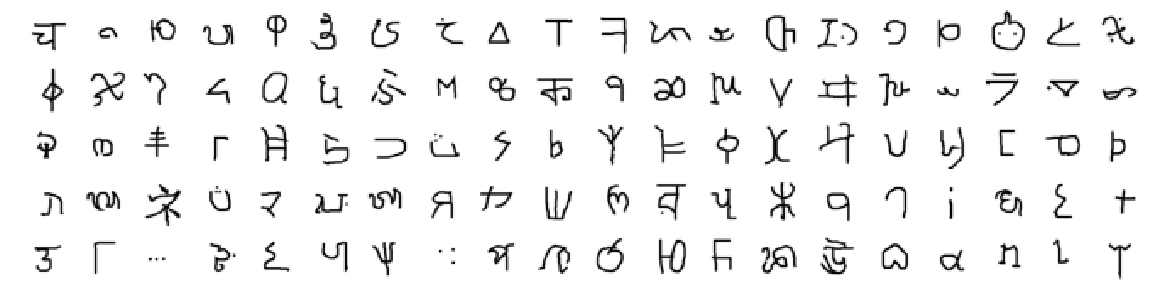

In [6]:
def getRandomImage( image_set, language_idx=None, character_idx=None, image_idx=None ):
    if language_idx is None:
        language_idx = np.random.randint( len( image_set ) )
    if character_idx is None:
        character_idx = np.random.randint( len( image_set[ language_idx ] ) )
    if image_idx is None:
        image_idx = np.random.randint( len( image_set[ language_idx ][ character_idx ] ) )
    return image_set[ language_idx ][ character_idx ][ image_idx ]

def plot_getRandomImage():
    return getRandomImage( background_languages )

plotImageGridFunc( plot_getRandomImage, ( 5, 20 ), plotsize=( 1, 1 ) )

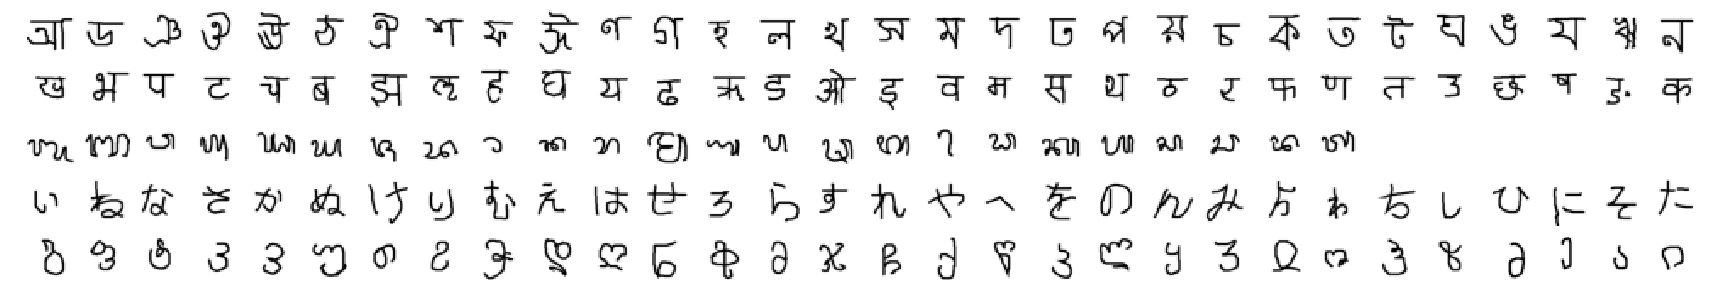

In [7]:
# Let's look at all the characters for a few different languages
# fig = plt.figure( figsize=( 40, 10 ) )
# subplots = fig.subplots( 5, 30 )
_random_languages = np.random.permutation( len( background_languages ) )

def plot_getRandomImage( row, col ):
    language_idx = _random_languages[ row ]
    character_idx = col
    if character_idx >= len( background_languages[ language_idx ] ):
        return None
    return getRandomImage( background_languages, language_idx, character_idx )

plotImageGridFunc( plot_getRandomImage, ( 5, 30 ), plotsize=( 1, 1 ) )

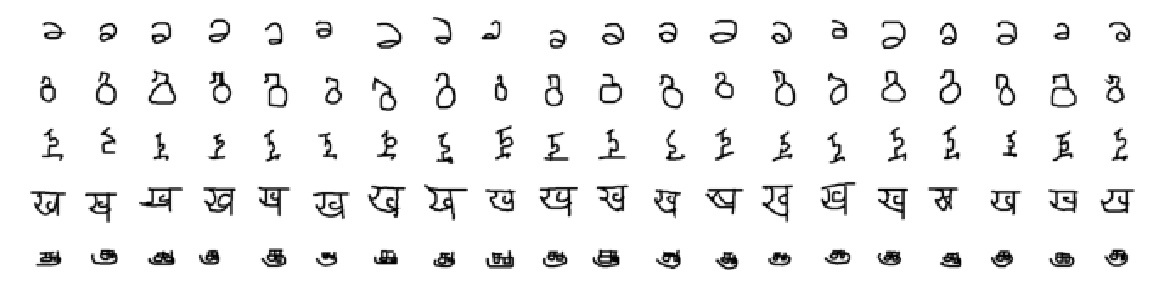

In [8]:
# Finally, let's look at all the drawings for a few different characters
_random_languages = np.random.permutation( len( background_languages ) )

def plot_getRandomImage( row, col ):
    return getRandomImage( background_languages, row, 0, col )

plotImageGridFunc( plot_getRandomImage, ( 5, 20 ), plotsize=( 1, 1 ) )

Notes / Thoughts:

 1. Different characters within a language seem to have similar characteristics (ie. some languages use alot of dots, some are very low detail), but be fairly visually different
 1. Different drawings of the same character can have pretty wide variation in size and stroke. Given this, it should be easy to augment the data by generating random zoom / offsets of the characters
     - May be able to do some "distortion" augmentation with randomly distorted characters
 1. All of the pixels are 1/0
 1. It seems like the images can be easily scaled down without losing much detail to improve training performance

### Research papers, external research

 - The [Lake et al. 2015](lake2015.pdf) paper that is attached to this dataset names a few different approaches
     - They mention that their baseline of simple [Hausdorff Distance](https://en.wikipedia.org/wiki/Hausdorff_distance) on centered images, they are able to get an error of 38%. Based on our problem statement, our target error is <35%, so this approach may work. Since it is fairly simple to implement we can try this first to get a feel for the problem and create some support tools.
     - The novel technique mentioned in this paper is Bayesian Program Learning (BCL) which attempts to break down characters into a sequence of "parts" or strokes taken when drawing the character. While this is an interesting approach, it is more complicated and less accurate than approaches found in later literature.
 - There are several other papers using the omniglot dataset and getting great results (Accuracy is listed as: 5-way 1-shot, 5-way 5-shot, 20-way 1-shot, 20-way 5-shot)
     - Matching networks (98.1%, 98.9%, 93.8%, 98.7%): https://arxiv.org/pdf/1606.04080.pdf
     - Convolutional Siamese Nets (97.3%, 98.4%, 88.1%, 97.0%): https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
     - Prototypical Network (98.8%, 99.9%, 96.0%, 98.9%): http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf

Based on my research it looks like the current state of the art algorithms are getting 99-95% accuracy on the defined tasks. 96% accuracy is what we can expect on the hardest version of the problem (20-way, 1-shot).

After this research I have decided to implement the Prototypical Network for a few reasons:
 - It shows the best accuracy on the problem
 - The paper uses downsized versions of the images (28x28 pixels). Which should allow me to train quickly on my poor hardware
 - The paper only uses 90 degree rotational augmentation, I want to try improving generalizability with other augmentations

### Model Support Code

To make it simpler down the line to train/test the model against the different data-sets, I am going to create some support code for the different sets

In [9]:
"""Example random prediction function used to test support code"""
def predictRandom( classes, test_images ):
    return np.random.randint( classes.shape[ 0 ] )

In [10]:
def getShots( character, shots=1 ):
    character_permutation = np.random.permutation( character.shape[ 0 ] )[ 0:shots ]
    return character[ character_permutation ]

def generateExample( characters, ways=None, shots=1, test_shots=1 ):
    """
    Generates a single challenge. Allows you to specify the ways and shots
    
    Args:
        characters: 4-rank matrix of characters ( characters, shots of character, image )
        ways: The number of classes that the agent must choose from to select the correct image. If None
            all characters will be present in test_images
        shots: The number of example images of each class
        test_shots: The number of example images of the test class (If None this is equal to shots)
    
    Returns: random_images, test_images, target_idx
        random_images: The selection images, one of which is the target class. Shape ( ways, shots, image size x, image size y )
        target_images: The "prompt" images. Shape ( test_shots, image size x, image size y )
        target_idx: The index of random_images that matches the target image
    """
    character_order = np.random.permutation( characters.shape[ 0 ] )

    random_characters = characters[ character_order ]

    if test_shots is None:
        test_shots = shots
    if ways is None:
        ways = len( characters ) - 1

    test_shot_images = getShots( random_characters[ 0 ], test_shots + shots )
    test_images = test_shot_images[ 0:test_shots ]
    target_images = test_shot_images[ test_shots: ]

    random_images = np.array( [ getShots( character, shots ) for character in random_characters[ 1:ways ] ] )
    random_images = np.append( random_images, target_images[ None, ... ], axis=0 )

    random_images_order = np.random.permutation( random_images.shape[ 0 ] )
    target_idx = np.where( random_images_order == random_images.shape[ 0 ] - 1 )[0][0]
    random_images = random_images[ random_images_order ]

    return random_images, test_images, target_idx

def plotExample( random_images, test_images ):
    plotImageGrid( np.rot90( random_images, axes=( 0, 1 ) ), plotsize=( 1, 1 ) )
    plotImageGrid( test_images[ None, ... ], plotsize=( 1, 1 ) )

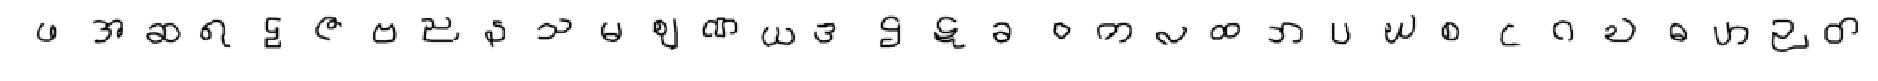

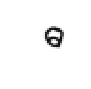

In [11]:
random_images, test_images, target_idx = generateExample( background_languages[ 0 ], ways=None, shots=1 )
plotExample( random_images, test_images )

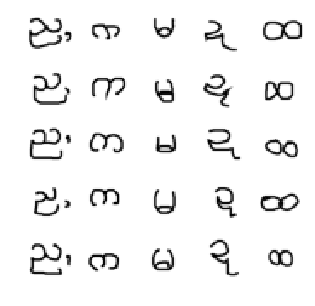

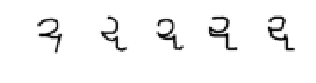

In [12]:
random_images, test_images, target_idx = generateExample( background_languages[ 0 ], ways=5, shots=5, test_shots=None )
plotExample( random_images, test_images )

In [13]:
def measureAccuracy( predict_func, test_samples=2000 ):
    way_options = [ None, 20, 5 ]
    shot_options = [ 5, 1 ]
    results = np.zeros( ( len( way_options ), len( shot_options ) ), dtype=np.int )

    with tqdm( total=np.product( results.shape ) * test_samples ) as pbar:
        for ways_i, ways in enumerate( way_options ):
            for shots_i, shots in enumerate( shot_options ):
                for i in range( test_samples ):
                    random_language = evaluation_languages[ np.random.randint( len( evaluation_languages ) ) ]
                    random_images, test_images, target_idx = generateExample( random_language, shots=shots, ways=ways )
                    predicted_idx = predict_func( random_images, test_images )
                    if predicted_idx == target_idx:
                        results[ ways_i, shots_i ] += 1
                    pbar.update( 1 )
    return [ results, test_samples ]

In [14]:
random_accuracy = measureAccuracy( predictRandom )

In [15]:
def printRow( text, width ):
    full_row = ''
    for i, item in enumerate( text ):
        if i != 0:
            full_row += ' | '
        full_row += str( item ).rjust( width, ' ' )
    print( full_row )
        

def printAccuracy( accuracy_matrix ):
    accuracy_matrix, test_samples = accuracy_matrix
    printRow( [ '', 'All-way', '20-way', '5-way' ], 8 )
    printRow( [ '5-shot' ] + list( accuracy_matrix[ :, 0 ] / test_samples ), 8 )
    printRow( [ '1-shot' ] + list( accuracy_matrix[ :, 1 ] / test_samples ), 8 )

printAccuracy( random_accuracy )

         |  All-way |   20-way |    5-way
  5-shot |    0.035 |   0.0455 |    0.201
  1-shot |   0.0365 |    0.038 |   0.2065


### First model: Hausdorff Distance minification

The Lake et al. 2015 paper compares their results to a baseline of choosing the centered image with the lowest Hausdorff Distance. This should be easy to build and evaulate

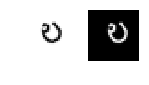

In [16]:
def prepareImage( image ):
    """
    Prepares the image for the Hausdorff distance.
    Centers the image based on cneter_of_mass, and flips the image so
    that 1s and 0s are flipped
    """
    image = 1 - image
    center_of_mass = scipy.ndimage.measurements.center_of_mass( image )
    centering_offset = ( ( np.array( image.shape ) / 2 ) - np.array( center_of_mass ) ).astype( np.int )
    image = np.roll( image, centering_offset )
    return image

_, center_test_images, _ = generateExample( background_languages[ 0 ], shots=1, ways=5 )

plotImageGrid( np.concatenate( [
    center_test_images[ 0 ][ None, None, ... ],
    prepareImage( center_test_images[ 0 ] )[ None, None, ... ]
], axis=1 ), plotsize=( 1, 1 ) )

In [17]:
def modifiedHausdorff( image_a, image_b ):
    """
    Does a modified Hausdorff comparison of the two images.

    WARNING: This is outrageously slow, as it has to calculate the distance between all points

    Modified Hausdorff is based on http://ieeexplore.ieee.org/xpls/abs_all.jsp?arnumber=576361

    d_point_set(a,B) = min( for b in B: | a - b | )
    d_set_set_directed(A,B) = average( for a in A: d_point_set( a, B ) )
    modified_hausdorff = max( d_set_set_directed(A,B), d_set_set_directed(B,A) )
    """
    a_points = np.argwhere( image_a >= 0.5 )
    b_points = np.argwhere( image_b >= 0.5 )

    dist = scipy.spatial.distance.cdist( a_points, b_points )

    d_A_B = np.mean( np.min( dist, axis=0 ) )
    d_B_A = np.mean( np.min( dist, axis=1 ) )

    return np.max( [ d_A_B, d_B_A ] )

mhd_test_random_images, mhd_test_test_image, _ = generateExample( background_languages[ 0 ], shots=1, ways=5 )

In [18]:
def predictHausdorff( classes, test_images ):
    test_image = prepareImage( test_images[ 0 ] )
    distances = np.zeros( classes.shape[ 0:2 ], dtype=np.float32 )
    for class_i, one_class in enumerate( classes ):
        for image_i, image in enumerate( one_class ):
            distances[ class_i, image_i ] = modifiedHausdorff( test_image, prepareImage( image ) )
    minimum = np.unravel_index( np.argmin( distances ), distances.shape )
    return minimum[ 0 ]

2
2


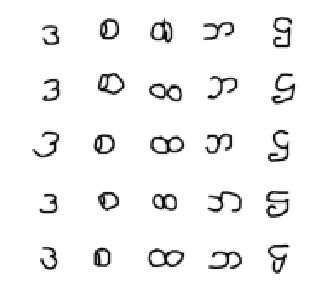

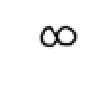

In [19]:
# Test hausdorff distance prediction
hausdorff_test_classes, hausdorff_test_test_image, hausdorff_test_target_idx = generateExample( background_languages[ 0 ], shots=5, ways=5 )

plotExample( hausdorff_test_classes, hausdorff_test_test_image )

print( hausdorff_test_target_idx )
print( predictHausdorff( hausdorff_test_classes, hausdorff_test_test_image ) )

In [20]:
hausdorff_accuracy = measureAccuracy( predictHausdorff )

In [21]:
printAccuracy( hausdorff_accuracy )

         |  All-way |   20-way |    5-way
  5-shot |   0.4905 |    0.557 |    0.764
  1-shot |    0.289 |    0.334 |    0.537


So it actually ended up being a bit harder than expected to set up the Modified Hausdorff Distance Object Matching as described in the [paper](papers/modified_hausdorff_anilK1994.pdf). But it was a fun excersize none-the-less so allwell.

### Next model: Prototypical Networks

Okay, now that we have a baseline to compare to, and a pretty good understanding of the problem scope, let's build our real model, the Prototypical Network

In [22]:
def randomlyMutate( support, query, random_rotation=None ):
    if random_rotation is None:
        rotations = [ 0, 90, 180, 270 ]
        random_rotation = rotations[ np.random.randint( len( rotations ) ) ]

    support = scipy.ndimage.rotate( support, random_rotation, axes=( 2, 3 ), mode='reflect' )
    query = scipy.ndimage.rotate( query, random_rotation, axes=( 2, 3 ), mode='reflect' )

    return support, query

def generateTrainingExample( language, classes=None, num_support=5, num_query=1, randomly_rotate_images=True ):
    if classes is None:
        classes = len( language )

    language_perm = np.random.permutation( len( language ) )[ :classes ]

    support = np.zeros( ( classes, num_support, ) + IMAGE_SIZE )
    query = np.zeros( ( classes, num_query, ) + IMAGE_SIZE )

    for class_i in range( classes ):
        characters = language[ class_i ]
        character_permutation = np.random.permutation( len( characters ) )
        support[ class_i, :, :, : ] = characters[ character_permutation[ :num_support ], ... ]
        query[ class_i, :, :, : ] = characters[ character_permutation[ num_support:num_support + num_query ], ... ]

    if randomly_rotate_images:
        support, query = randomlyMutate( support, query )

    return support, query

# def generateTrainingExample( language, classes=None, num_support=5, num_query=1, randomly_rotate_images=True ):
#     if classes is None:
#         classes = len( language )
#     classes = min( len( language ), classes )

#     language_perm = np.random.permutation( len( language ) )[ :classes ]
# #     language_perm = language[ np.random.permutation( len( language ) )[ :classes ] ]

#     support = np.zeros( ( classes, num_support, ) + IMAGE_SIZE )
#     query = np.zeros( ( classes, num_query, ) + IMAGE_SIZE )

#     for class_i in range( classes ):
#         characters = language[ class_i ]
#         character_permutation = np.random.permutation( len( characters ) )
#         support[ class_i, :, :, : ] = characters[ character_permutation[ :num_support ], ... ]
#         query[ class_i, :, :, : ] = characters[ character_permutation[ num_support:num_support + num_query ], ... ]

#     if randomly_rotate_images:
#         support, query = randomlyMutate( support, query )
        
#     return support, query

In [23]:
class ProtonetModel():
    """
    Class for the protonet model.
    Based on the protypical networks paper.
    """
    def __init__(
        self, 
        sess, 
        embedding_filters=[ 64, 64, 64, 64 ],
        
        model_save_dir='data/models/',
        model_save_fn='default.cpkt'
    ):
        self.model_save_dir = model_save_dir
        self.model_save_fn = model_save_fn

        # Inputs are of shape:
        #     support_classes ( Nc, Ns, 28, 28 )
        #     input_query ( Nc, Nq, 28, 28 )
        # Where:
        #     Nc = Num Classes
        #     Ns = Num support examples
        #     Nq = Num query examples
        # When training we input the query classes in the
        # same order as the support classes
        self.support_classes_ph = tf.placeholder( shape=( None, None, ) + IMAGE_SIZE, dtype=tf.float32, name='support_classes_input' )
        self.query_classes_ph = tf.placeholder( shape=( None, None, ) + IMAGE_SIZE, dtype=tf.float32, name='query_classes_input' )

        Nc = tf.shape( self.support_classes_ph )[ 0 ]
        Ncq = tf.shape( self.query_classes_ph )[ 0 ]
        tf.Assert( tf.equal( Nc, Ncq ), data=[ Nc ] )
        Ns = tf.shape( self.support_classes_ph )[ 1 ]
        Nq = tf.shape( self.query_classes_ph )[ 1 ]

        # Combine support classes and input classes so we can embed them all at once
        merged = tf.concat( [
            tf.reshape( self.support_classes_ph, shape=( -1, ) + IMAGE_SIZE ),
            tf.reshape( self.query_classes_ph, shape=( -1, ) + IMAGE_SIZE )
        ], axis=0 )

        merged = tf.expand_dims( merged, -1 )

        # Embed the values with our current network
        embedded = self.embeddingNetwork( merged, filters=embedding_filters )

        # Un-Combine support classes and input classes
        embedded_support = tf.reshape( embedded[ : Nc * Ns ], ( Nc, Ns, -1 ) )
        embedded_query = embedded[ Nc * Ns : ]

        # Generate prototypes for all support classes
        support_class_prototypes = tf.reduce_mean( embedded_support, axis=1 )

        distances = self.euclideanDistance( embedded_query, support_class_prototypes )

        log_probs = tf.nn.log_softmax( -distances )

        self.losses = tf.diag_part( log_probs )
        self.loss = -tf.reduce_mean( self.losses )

        summary_loss = tf.summary.scalar( "loss", self.loss )

        self.preds = tf.argmax( log_probs, axis=1 )

        self.learning_rate = tf.Variable( 0.01, dtype=tf.float32 )
        optimizer = tf.train.AdamOptimizer( learning_rate=self.learning_rate )
        self.optimize_op = optimizer.minimize( self.loss )

        self.merge_op = tf.summary.merge_all()
        
        self.sess = sess

    def convBlock( self, input_layer, name, filters ):
        x = tf.layers.conv2d(
            inputs=input_layer,
            filters=64,
            kernel_size=(3, 3),
            name=name + 'conv',
            padding="same"
        )
        x = tf.layers.batch_normalization( x, name=name + 'bn' )
        x = tf.nn.relu( x, name=name + 'relu' )
        x = tf.layers.max_pooling2d(
            inputs=x,
            pool_size=( 2, 2 ),
            strides=2,
            name=name + 'mp'
        )
        return x

    def getModelSavePath( self ):
        return os.path.join( self.model_save_dir, self.model_save_fn )
    
    def embeddingNetwork( self, input_layer, filters ):
        x = input_layer
        for i, layer_filters in enumerate( filters ):
            x = self.convBlock( x, 'embedding' + str( i ) + '_', layer_filters )
        x = tf.layers.flatten( x )
        return x

    def euclideanDistance( self, input_n, input_m ):
        input_n = tf.expand_dims( input_n, axis=1 )
        input_m = tf.expand_dims( input_m, axis=0 )

        return tf.reduce_sum( ( tf.subtract( input_n, input_m ) ** 2 ), axis=2 )
        
    def feedDict( self, episode, custom_learning_rate=None ):
        feed_dict = {
            self.support_classes_ph: episode[ 0 ],
            self.query_classes_ph: episode[ 1 ]
        }       
        if custom_learning_rate is not None:
            feed_dict[ self.learning_rate ] = custom_learning_rate
        return feed_dict

    def train( 
            self,
            sess,
            train_episodes=12000, 
            summary_dir='data/logs/', 

            learning_rate_start=0.01,
            learning_rate_decay=0.5,
            learning_rate_decay_time=2000,
        
            # How often to print episode/loss, None for silent
            print_status_interval=None,

            randomly_rotate_images=True,

            episode_classes=None,
            episode_num_support=5,
            episode_num_query=1,

            # Allow you to log every some number of episodes in order to
            # figure out what is causing crazy loss changes
            log_episode_interval=None
        ):
        """
        Trains the model using it's expected episode format.

        Allows as much as possible to be editable for experiments
        """
        custom_learning_rate = 0.01

        saver = tf.train.Saver()
        writer = tf.summary.FileWriter( 'data/logs/', graph=tf.get_default_graph() )
        logged_episodes = []
        logged_losses = np.array( [], dtype=np.float32 )
        logged_all_losses = []
        for step in tqdm( range( train_episodes ) ):
            random_language = background_languages[ np.random.randint( len( background_languages ) ) ]
            training_example = generateTrainingExample(
                random_language, 
                classes=episode_classes, num_support=episode_num_support, num_query=episode_num_query,
                randomly_rotate_images=randomly_rotate_images
            )

            training_loss, _, merged_summaries, losses = self.sess.run( 
                ( self.loss, self.optimize_op, self.merge_op, self.losses ), 
                feed_dict=self.feedDict( training_example, custom_learning_rate=custom_learning_rate ) 
            )
            writer.add_summary( merged_summaries, global_step=i )

            if log_episode_interval and step % log_episode_interval == 0:
                logged_episodes.append( [ training_example ] )
                logged_losses = np.append( logged_losses, training_loss )
                logged_all_losses.append( losses )

            if print_status_interval is not None and step % print_status_interval == 0:
                print( 'Episode: ', step, ' loss:', training_loss )

            if step % learning_rate_decay_time == 0 and step != 0:
                custom_learning_rate *= learning_rate_decay
                if print_status_interval is not None:
                    print( 'Changed lr: ', custom_learning_rate )

        saver.save( self.sess, self.getModelSavePath() )
        return logged_episodes, logged_losses, logged_all_losses

    def predict( self, classes, query ):
        """
        Does prediction in the format that our measureAccuracy function expects
        """
        query = query[ None, ... ]
        query = np.repeat( query, classes.shape[ 0 ], axis=0 )
        predictions = self.sess.run( self.preds, feed_dict=self.feedDict( [ classes, query ] ) )

        return predictions[ 0 ]

In [24]:
def testParams(
    initialize=True, 
    load=False, 
    train=True, 
    test_samples=2000,
    model_save_dir='data/models/',
    model_save_fn='default.cpkt',
    **params
):
    with tf.Graph().as_default():
        with tf.Session() as sess:
            model = ProtonetModel(
                sess,
                model_save_dir=model_save_dir,
                model_save_fn=model_save_fn
            )

            if initialize:
                sess.run( tf.global_variables_initializer() )
            if load:
                load_saver = tf.train.Saver()
                load_saver.restore( sess, model.getModelSavePath() )

            train_results = None
            if train:
                train_results = model.train( sess, **params )
            accuracy = measureAccuracy( model.predict )
            printAccuracy( accuracy )
            return train_results, accuracy

In [25]:
### Test with default parameters
testParams( model_save_fn='default-1.cpkt' )

Instructions for updating:
keep_dims is deprecated, use keepdims instead



         |  All-way |   20-way |    5-way
  5-shot |    0.693 |    0.745 |   0.9075
  1-shot |    0.508 |   0.5555 |   0.8015


(([], array([], dtype=float32), []), [array([[1386, 1016],
         [1490, 1111],
         [1815, 1603]]), 2000])

In [26]:
### Test with default parameters
testParams( model_save_fn='default-1.cpkt', load=True, train=False )

INFO:tensorflow:Restoring parameters from data/models/default-1.cpkt



         |  All-way |   20-way |    5-way
  5-shot |   0.7185 |     0.76 |   0.9035
  1-shot |   0.4905 |   0.5765 |    0.788


(None, [array([[1437,  981],
         [1520, 1153],
         [1807, 1576]]), 2000])

Well it's built, and it seems to be running okay.

Next steps:

 - Analyze failure cases
 - Analyze why loss seems to have such high variance

### Why does loss have such a high variance?

From logging on Tensorboard it seems like there is a big spike down in loss, and then really high variance in the loss after that.

In [ ]:
# Let's try to look at what's causing such high training variance. Log some episodes

train_results, accuracy = testParams( log_episode_interval=100 )

In [ ]:
losses = train_results[ 1 ]
plt.plot( losses )

In [ ]:
second_half_losses = losses[ 60: ]
sorted_loss_idxes = second_half_losses.argsort()
print( sorted_loss_idxes )

In [ ]:
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 0 ] ][ 0 ][ 0 ] ), plotsize=( 1, 1 ) )
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 0 ] ][ 0 ][ 1 ] ), plotsize=( 1, 1 ) )
print( train_results[ 2 ][ sorted_loss_idxes[ 0 ] ] )

In [ ]:
plt.hist( train_results[ 2 ][ sorted_loss_idxes[ 0 ] ] )

In [ ]:
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 1 ] ][ 0 ][ 0 ] ), plotsize=( 1, 1 ) )
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 1 ] ][ 0 ][ 1 ] ), plotsize=( 1, 1 ) )
print( train_results[ 2 ][ sorted_loss_idxes[ 1 ] ] )

In [ ]:
_ = plt.hist( train_results[ 2 ][ sorted_loss_idxes[ 1 ] ] )

In [ ]:
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 2 ] ][ 0 ][ 0 ] ), plotsize=( 1, 1 ) )
plotImageGrid( np.rot90( train_results[ 0 ][ sorted_loss_idxes[ 2 ] ][ 0 ][ 1 ] ), plotsize=( 1, 1 ) )
print( train_results[ 2 ][ sorted_loss_idxes[ 2 ] ] )

In [ ]:
_ = plt.hist( train_results[ 2 ][ sorted_loss_idxes[ 2 ] ] )